In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.figure as fgr
from matplotlib.pyplot import figure
import seaborn as sns
import time
import os
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import MinMaxScaler,StandardScaler, RobustScaler, MaxAbsScaler, LabelEncoder, OneHotEncoder, PowerTransformer
from sklearn.metrics import mean_squared_error,accuracy_score,recall_score,precision_score,f1_score,roc_auc_score
from sklearn.model_selection import train_test_split, RepeatedKFold, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import make_scorer, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
import pylab
from scipy.stats import skew

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [2]:
train_df = pd.read_csv("dataset_sdn.csv")

In [3]:
train_df.head()

,dt,switch,src,dst,pktcount,bytecount,dur,dur_nsec,tot_dur,flows,...,pktrate,Pairflow,Protocol,port_no,tx_bytes,rx_bytes,tx_kbps,rx_kbps,tot_kbps,label
0,11425,1,10.0.0.1,10.0.0.8,45304,48294064,100,716000000,1.010000e+11,3,...,451,0,UDP,3,143928631,3917,0,0.0,0.0,0
1,11605,1,10.0.0.1,10.0.0.8,126395,134737070,280,734000000,2.810000e+11,2,...,451,0,UDP,4,3842,3520,0,0.0,0.0,0
2,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,...,451,0,UDP,1,3795,1242,0,0.0,0.0,0
3,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,...,451,0,UDP,2,3688,1492,0,0.0,0.0,0
4,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,...,451,0,UDP,3,3413,3665,0,0.0,0.0,0


In [4]:
print(train_df.shape)
train_df.info()

(104345, 23)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104345 entries, 0 to 104344
Data columns (total 23 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   dt           104345 non-null  int64  
 1   switch       104345 non-null  int64  
 2   src          104345 non-null  object 
 3   dst          104345 non-null  object 
 4   pktcount     104345 non-null  int64  
 5   bytecount    104345 non-null  int64  
 6   dur          104345 non-null  int64  
 7   dur_nsec     104345 non-null  int64  
 8   tot_dur      104345 non-null  float64
 9   flows        104345 non-null  int64  
 10  packetins    104345 non-null  int64  
 11  pktperflow   104345 non-null  int64  
 12  byteperflow  104345 non-null  int64  
 13  pktrate      104345 non-null  int64  
 14  Pairflow     104345 non-null  int64  
 15  Protocol     104345 non-null  object 
 16  port_no      104345 non-null  int64  
 17  tx_bytes     104345 non-null  int64  
 18  rx_bytes   

In [5]:
train_df.head().T

,0,1,2,3,4
dt,11425,11605,11425,11425,11425
switch,1,1,1,1,1
src,10.0.0.1,10.0.0.1,10.0.0.2,10.0.0.2,10.0.0.2
dst,10.0.0.8,10.0.0.8,10.0.0.8,10.0.0.8,10.0.0.8
pktcount,45304,126395,90333,90333,90333
bytecount,48294064,134737070,96294978,96294978,96294978
dur,100,280,200,200,200
dur_nsec,716000000,734000000,744000000,744000000,744000000
tot_dur,101000000000.0,281000000000.0,201000000000.0,201000000000.0,201000000000.0
flows,3,2,3,3,3


In [6]:
print(train_df.label.value_counts())

label
0    63561
1    40784
Name: count, dtype: int64


In [7]:
print(train_df.Protocol.value_counts())

Protocol
ICMP    41321
UDP     33588
TCP     29436
Name: count, dtype: int64


In [8]:
train_df.isnull().sum()

dt               0
switch           0
src              0
dst              0
pktcount         0
bytecount        0
dur              0
dur_nsec         0
tot_dur          0
flows            0
packetins        0
pktperflow       0
byteperflow      0
pktrate          0
Pairflow         0
Protocol         0
port_no          0
tx_bytes         0
rx_bytes         0
tx_kbps          0
rx_kbps        506
tot_kbps       506
label            0
dtype: int64

In [9]:
train_df.describe()

,dt,switch,pktcount,bytecount,dur,dur_nsec,tot_dur,flows,packetins,pktperflow,byteperflow,pktrate,Pairflow,port_no,tx_bytes,rx_bytes,tx_kbps,rx_kbps,tot_kbps,label
count,104345.000000,104345.000000,104345.000000,1.043450e+05,104345.000000,1.043450e+05,1.043450e+05,104345.000000,104345.000000,104345.000000,1.043450e+05,104345.000000,104345.000000,104345.000000,1.043450e+05,1.043450e+05,104345.000000,103839.000000,103839.000000,104345.000000
mean,17927.514169,4.214260,52860.954746,3.818660e+07,321.497398,4.613880e+08,3.218865e+11,5.654234,5200.383468,6381.715291,4.716150e+06,212.210676,0.600987,2.331094,9.325264e+07,9.328039e+07,998.899756,1003.811420,2007.578742,0.390857
std,11977.642655,1.956327,52023.241460,4.877748e+07,283.518232,2.770019e+08,2.834029e+11,2.950036,5257.001450,7404.777808,7.560116e+06,246.855123,0.489698,1.084333,1.519380e+08,1.330004e+08,2423.471618,2054.887034,3144.437173,0.487945
min,2488.000000,1.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,2.000000,4.000000,-130933.000000,-1.464426e+08,-4365.000000,0.000000,1.000000,2.527000e+03,8.560000e+02,0.000000,0.000000,0.000000,0.000000
25%,7098.000000,3.000000,808.000000,7.957600e+04,127.000000,2.340000e+08,1.270000e+11,3.000000,1943.000000,29.000000,2.842000e+03,0.000000,0.000000,1.000000,4.743000e+03,3.539000e+03,0.000000,0.000000,0.000000,0.000000
50%,11905.000000,4.000000,42828.000000,6.471930e+06,251.000000,4.180000e+08,2.520000e+11,5.000000,3024.000000,8305.000000,5.521680e+05,276.000000,1.000000,2.000000,4.219610e+06,1.338339e+07,0.000000,0.000000,4.000000,0.000000
75%,29952.000000,5.000000,94796.000000,7.620354e+07,412.000000,7.030000e+08,4.130000e+11,7.000000,7462.000000,10017.000000,9.728112e+06,333.000000,1.000000,3.000000,1.356398e+08,1.439277e+08,251.000000,557.000000,3838.000000,1.000000
max,42935.000000,10.000000,260006.000000,1.471280e+08,1881.000000,9.990000e+08,1.880000e+12,17.000000,25224.000000,19190.000000,1.495387e+07,639.000000,1.000000,5.000000,1.269982e+09,9.905962e+08,20580.000000,16577.000000,20580.000000,1.000000


In [10]:
numeric_df = train_df.select_dtypes(include=['int64', 'float64'])
object_df = train_df.select_dtypes(include=['object'])
print('Числовые: ', numeric_df.columns)
print('Объектные: ', object_df.columns)

Числовые:  Index(['dt', 'switch', 'pktcount', 'bytecount', 'dur', 'dur_nsec', 'tot_dur',
       'flows', 'packetins', 'pktperflow', 'byteperflow', 'pktrate',
       'Pairflow', 'port_no', 'tx_bytes', 'rx_bytes', 'tx_kbps', 'rx_kbps',
       'tot_kbps', 'label'],
      dtype='object')
Объектные:  Index(['src', 'dst', 'Protocol'], dtype='object')


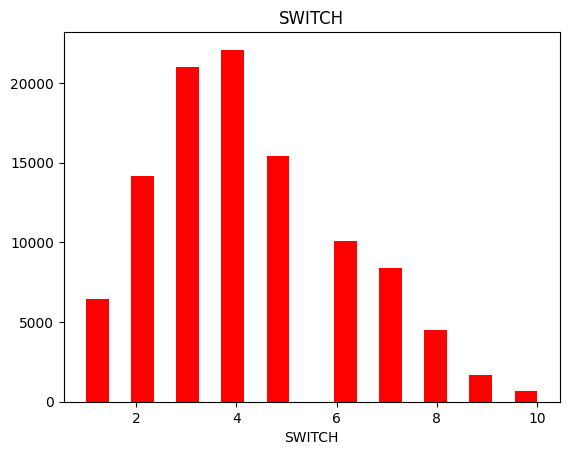

In [11]:
plt.hist(train_df.switch, bins=20, color='r')
plt.title('SWITCH')
plt.xlabel('SWITCH')
plt.show()

In [ ]:
import pandas as pd


df = train_df

# Количество сетевых элементов
num_switches = df['switch'].nunique()
unique_src_ips = df['src'].nunique()
unique_dst_ips = df['dst'].nunique()
num_hosts_approx = unique_src_ips + unique_dst_ips # Оценка сверху из-за возможного дублирования IP

num_flows_aggregated = df[['src', 'dst', 'Protocol']].drop_duplicates().shape[0]

print(f"Количество коммутаторов: {num_switches}")
print(f"Приблизительное количество хостов: {num_hosts_approx}")
print(f"Количество агрегированных потоков: {num_flows_aggregated}")

# Анализ длины потоков
df['duration_sec'] = df['dur'] + df['dur_nsec'] / 1e9  # Переводим в секунды

# Разделение по label
df_normal = df[df['label'] == 0]
df_attack = df[df['label'] == 1]

# Функции для анализа
def analyze_flows(df, label):
    print(f"Анализ для label = {label}:")

    # Длина потоков
    print("\nДлина потоков (в секундах):")
    print(f"  Среднее: {df['duration_sec'].mean()}")
    print(f"  Медиана: {df['duration_sec'].median()}")
    print(f"  Минимум: {df['duration_sec'].min()}")
    print(f"  Максимум: {df['duration_sec'].max()}")
    print(f"  Квартили:\n{df['duration_sec'].quantile([0.25, 0.5, 0.75])}")

    # Количество пакетов
    print("\nКоличество пакетов:")
    print(f"  Среднее: {df['pktcount'].mean()}")
    print(f"  Медиана: {df['pktcount'].median()}")
    print(f"  Минимум: {df['pktcount'].min()}")
    print(f"  Максимум: {df['pktcount'].max()}")
    print(f"  Квартили:\n{df['pktcount'].quantile([0.25, 0.5, 0.75])}")


analyze_flows(df_normal, 0)
analyze_flows(df_attack, 1)


Количество коммутаторов: 10
Приблизительное количество хостов: 37
Количество агрегированных потоков: 217
Анализ для label = 0:

Длина потоков (в секундах):
  Среднее: 344.3175906609399
  Медиана: 249.908
  Минимум: 0.004
  Максимум: 1881.469
  Квартили:
0.25    131.690
0.50    249.908
0.75    500.213
Name: duration_sec, dtype: float64

Количество пакетов:
  Среднее: 36113.201192555185
  Медиана: 999.0
  Минимум: 0
  Максимум: 260006
  Квартили:
0.25      478.0
0.50      999.0
0.75    68299.0
Name: pktcount, dtype: float64
Анализ для label = 1:

Длина потоков (в секундах):
  Среднее: 287.11306284327185
  Медиана: 260.06
  Минимум: 0.0
  Максимум: 1881.465
  Квартили:
0.25    113.358
0.50    260.060
0.75    368.109
Name: duration_sec, dtype: float64

Количество пакетов:
  Среднее: 78961.97386229894
  Медиана: 80605.5
  Минимум: 0
  Максимум: 259998
  Квартили:
0.25     35541.0
0.50     80605.5
0.75    119166.0
Name: pktcount, dtype: float64


In [ ]:
import pandas as pd
import numpy as np

df = train_df

print("Изучение протоколов")
protocol_counts = df['Protocol'].value_counts()
print("Распределение протоколов:")
print(protocol_counts)

print(" Потенциальные аномалии")

#  выбросы по длительности потока
q1 = df['duration_sec'].quantile(0.25)
q3 = df['duration_sec'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers_duration = df[(df['duration_sec'] < lower_bound) | (df['duration_sec'] > upper_bound)]
print(f"Количество выбросов по длительности потока: {len(outliers_duration)}")

q1 = df['pktcount'].quantile(0.25)
q3 = df['pktcount'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers_pktcount = df[(df['pktcount'] < lower_bound) | (df['pktcount'] > upper_bound)]
print(f"Количество выбросов по количеству пакетов: {len(outliers_pktcount)}")


Изучение протоколов
Распределение протоколов:
Protocol
ICMP    41321
UDP     33588
TCP     29436
Name: count, dtype: int64
 Потенциальные аномалии
Количество выбросов по длительности потока: 7682
Количество выбросов по количеству пакетов: 633
